#### Goal: Simulate arcs

In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_6/Simulation_Data/"

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [2]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
kappa_ = 1.1                                                         #kappa_s of DM profile
r_s    = 2.0                                                         #scale radius
q      = 0.85                                                          #Axis Ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

To simulate an image, we need to model the telescope’s optics. We’ll do this by convolving the image with a Point-Spread Function using a Kernel object, which we can simulate as a Gaussian. We also simulated a grid.

In [3]:
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.01, pixel_scales=0.1)
grid = al.Grid.uniform(shape_2d=(100, 100), pixel_scales=0.1, sub_size=1)

## Starting model
Here we define the lens mass profile (MGE in our case)

In [4]:

#Initializing
ell_comps = al.convert.elliptical_comps_from(axis_ratio=q, phi=0.0) #Elliptical components in Pyautolens units
mass_profile = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

And here we define a source galaxy

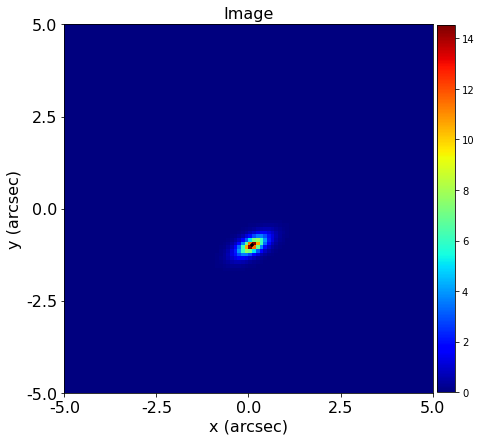

In [24]:
#Source galaxy
source_galaxy = al.Galaxy(
    redshift=z_s,
    bulge=al.lp.EllipticalSersic(
        centre=(-1, 0.1),
        elliptical_comps=(0.3, 0.2),
        intensity=5.0,
        effective_radius=0.23,
        sersic_index=0.8,
    ),
)

#Ploting our source galaxy
output=aplt.Output(path=data_folder,filename="Souce_galaxy.fits", format="fits")
plotter = aplt.Plotter(
    figure=aplt.Figure(figsize=(7, 7)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)

#aplt.Galaxy.image(galaxy=source_galaxy, grid=grid, plotter=plotter) #Save as fits
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)                  #Plot

Lets look at the Tracer’s image - this is the image we’ll be simulating.

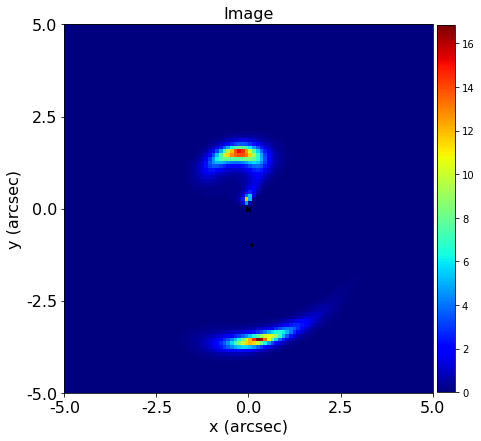

0.35328279600071255


In [25]:
time = clock()
#Tracing the deflection angles
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
aplt.Tracer.image(tracer=tracer, grid=grid,  include=aplt.Include(critical_curves=False,caustics=False))
print(clock() - time)

In [26]:
time = clock()

normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_2d
)
print(normal_image.shape)
print(padded_image.shape)

print(clock() - time)

(10000,)
(12100,)
0.3211220160010271


Now, to simulate the Imaging data, we pass the Tracer and Grid to the Imaging module’s simulate function. This adds the following effects to the image:


    Telescope optics: Using the Point Spread Function above.
    The Background Sky: Although the image that is returned is automatically background sky subtracted.
    Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.

In [27]:
time = clock()

simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.0001, shape_2d=grid.shape_2d),
    add_noise=False,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

print(clock() - time)

0.18610539600194898


Lets plot the image - we can see the image has been blurred due to the telescope optics and noise has been added.

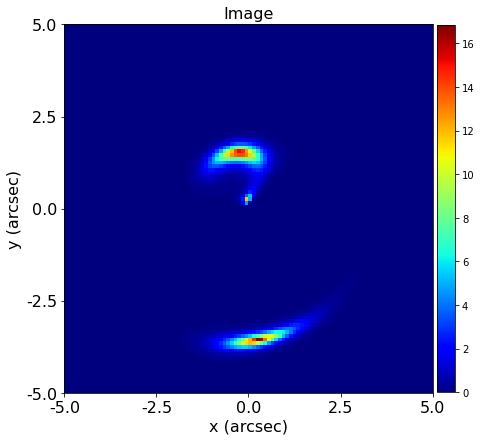

In [28]:
aplt.Imaging.image(imaging=imaging)

Finally, lets output these files to.fits files.

In [29]:
imaging.output_to_fits(
    image_path=f"{data_folder}/arcs_simulation.fits",
    noise_map_path=f"{data_folder}/noise_simulation.fits",
    psf_path=f"{data_folder}/psf_simulation.fits",
    overwrite=True,
)

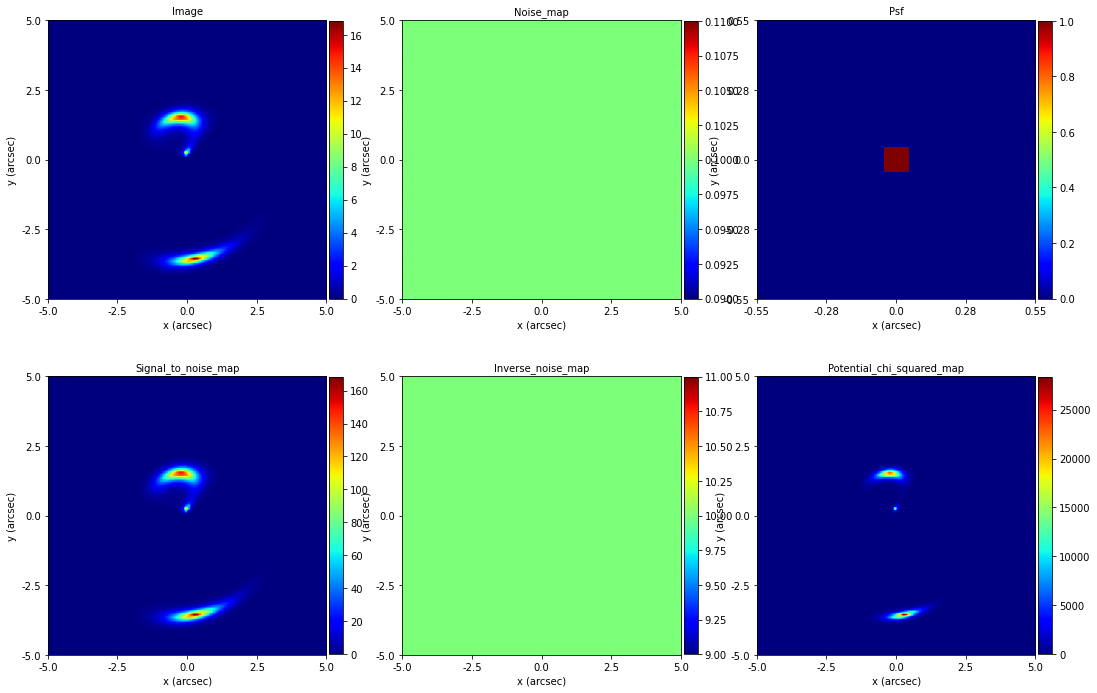

In [30]:
#Load data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

aplt.Imaging.subplot_imaging(imaging)